# TP4 Projeto de Bloco: Inteligência Artificial e Machine Learning [24E3_5]
# Alberto F. Pluecker - 16.11.2024
https://colab.research.google.com/drive/1VRt_WAhvcVwWl6Q2RmNXsjQ84n08IVTz?usp=sharing

In [6]:
import pandas as pd

data = pd.read_csv('/content/diabetes.csv').dropna()
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1. Clusterização K-Médias: Utilizaremos o algoritmo K-Médias para agrupar os dados do conjunto de treinamento. O número ótimo de clusters será determinado com base em métricas como o método do cotovelo e o índice de silhueta.

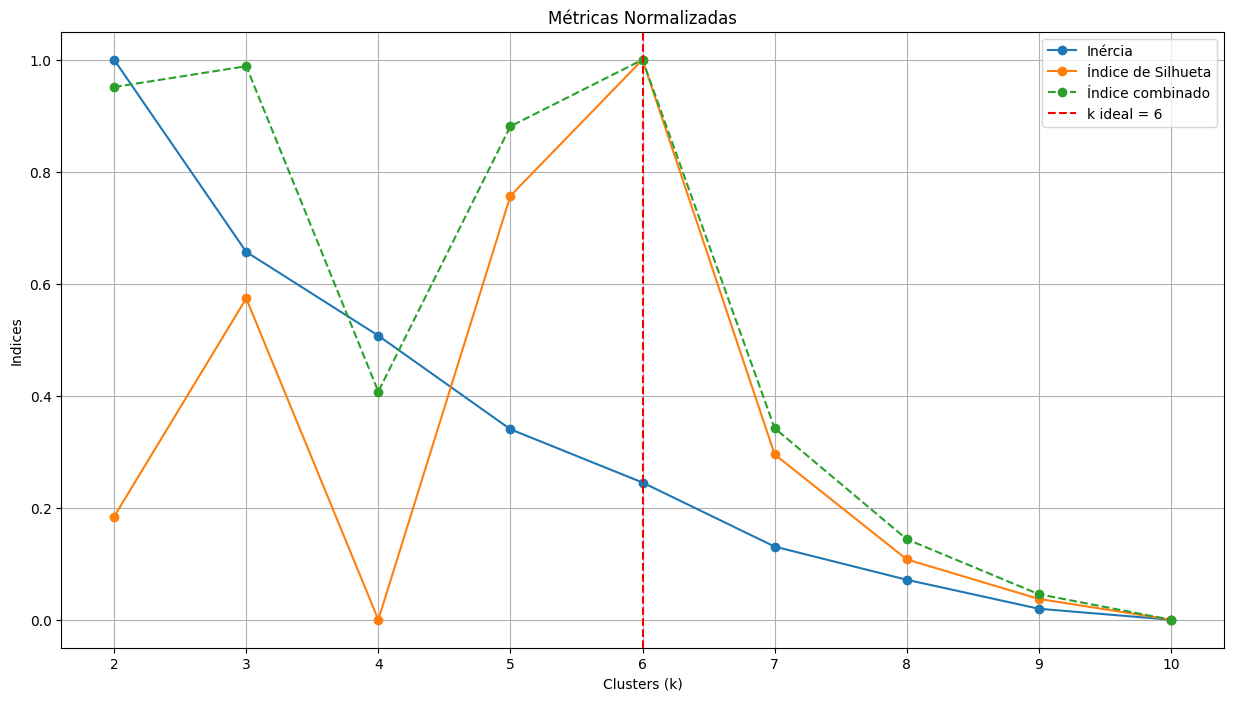

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

target_column = 'Outcome'
features = data.drop(columns=[target_column])
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)


max_clusters = 10
weight_distortion = 0.5
weight_silhouette = 0.5

def normalize_array(array):
  return (array - array.min()) / (array.max() - array.min())

def find_optimal_k(max_clusters: int, normalized_features, weight_distortion: float, weight_silhouette: float):
    if weight_distortion <= 0 or weight_silhouette <= 0:
        raise ValueError("Pesos devem ser positivos")

    distortions = []
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(normalized_features)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(normalized_features, kmeans.labels_))

    distortions = np.array(distortions)
    silhouette_scores = np.array(silhouette_scores)

    normalized_distortions = normalize_array(distortions)
    normalized_silhouette = normalize_array(silhouette_scores)

    distortion_range = normalized_distortions.max() - normalized_distortions.min()
    silhouette_range = normalized_silhouette.max() - normalized_silhouette.min()
    scaling_factor = silhouette_range / distortion_range
    scaled_distortions = normalized_distortions * scaling_factor

    combined_scores = (
        (weight_distortion * scaled_distortions +
        weight_silhouette * normalized_silhouette)/ (weight_silhouette + weight_distortion)
    )

    optimal_k = np.argmax(combined_scores) + 2

    return optimal_k, distortions, silhouette_scores, combined_scores

optimal_k, distortions, silhouette_scores, combined_scores = find_optimal_k(max_clusters, normalized_features, weight_distortion, weight_silhouette)

def plot_metrics(distortions, silhouette_scores, combined_scores):
    normalized_distortions = normalize_array(np.array(distortions))
    normalized_silhouette = normalize_array(np.array(silhouette_scores))
    normalized_combined_scores = normalize_array(np.array(combined_scores))

    plt.figure(figsize=(15, 8))
    plt.plot(range(2, max_clusters + 1), normalized_distortions, label="Inércia", marker='o')
    plt.plot(range(2, max_clusters + 1), normalized_silhouette, label="Índice de Silhueta", marker='o')
    plt.plot(range(2, max_clusters + 1), normalized_combined_scores, label="Índice combinado", marker='o', linestyle='--')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f"k ideal = {optimal_k}")
    plt.title("Métricas Normalizadas")
    plt.xlabel("Clusters (k)")
    plt.ylabel("Indices")
    plt.legend()
    plt.grid()
    plt.show()

plot_metrics(distortions, silhouette_scores, combined_scores)

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(normalized_features)

## 2. Criação de Features: Para cada instância nos conjuntos de treinamento e teste, será gerada uma nova feature indicando a distância da instância ao centro do cluster mais próximo. Este processo visa incorporar a estrutura de agrupamento dos dados como uma informação adicional para o modelo de aprendizado supervisionado.

In [8]:
from sklearn.metrics import pairwise_distances_argmin_min

# Ajustar K-Means ao conjunto de treinamento
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(normalized_features)

# Função para calcular a distância ao centroide mais próximo
def compute_nearest_cluster_distance(features, kmeans):
    _, distances = pairwise_distances_argmin_min(features, kmeans.cluster_centers_)
    return distances

# Criar a nova feature para o conjunto de treinamento
train_distances = compute_nearest_cluster_distance(normalized_features, kmeans)

# Adicionar a nova feature ao conjunto de dados
data['Distance_to_Cluster'] = train_distances

print("Nova feature adicionada ao conjunto de dados:")
print(data.head())

Nova feature adicionada ao conjunto de dados:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  Cluster  Distance_to_Cluster  
0                     0.627   50        1        4             1.351537  
1                     0.351   31        0        5             1.177590  
2                     0.672   32        1        1             2.552727  
3                     0.167   21        0        5             0.991350  
4                     2.288   33        1        3             4.165763  


## 3. Modelo de ML: Serão treinados utilizando tanto o conjunto de features original quanto o conjunto de features expandido com as distâncias dos clusters. Use:

* a. Modelos SVM com diferentes configurações de kernel (linear, polinomial, RBF) e parâmetros de regularização para otimizar o desempenho.
* b. Modelos Random Forest com diferentes parâmetros para otimizar o desempenho.


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Função para treinar e avaliar SVM
def train_and_evaluate_svm(train_features, train_target, test_features, test_target, kernels):
    models = {}
    for kernel in kernels:
        print(f"\nTreinando SVM com kernel: {kernel}")
        svm = SVC(kernel=kernel, C=1.0, random_state=42)
        svm.fit(train_features, train_target)
        predicted_target = svm.predict(test_features)
        print(f"Acurácia: {accuracy_score(test_target, predicted_target):.4f}")
        print(classification_report(test_target, predicted_target))
        models[kernel] = svm
    return models

# Função para treinar e avaliar Random Forest
def train_and_evaluate_rf(train_features, train_target, test_features, test_target, n_estimators):
    models = {}
    for n in n_estimators:
        print(f"\nTreinando Random Forest com n_estimators={n}")
        random_forest = RandomForestClassifier(n_estimators=n, max_depth=10, random_state=42)
        random_forest.fit(train_features, train_target)
        predicted_target = random_forest.predict(test_features)
        print(f"Acurácia: {accuracy_score(test_target, predicted_target):.4f}")
        print(classification_report(test_target, predicted_target))
        models[n] = random_forest
    return models

# Função para otimização de hiperparâmetros com RandomizedSearchCV
def optimize_hyperparameters(model, param_grid, train_features, train_target, n_iter=5, cv=3):
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    randomized_search.fit(train_features, train_target)
    print(f"Melhores hiperparâmetros para {type(model).__name__}:")
    print(randomized_search.best_params_)
    return randomized_search.best_params_

# Preparação dos dados
features = data.drop(columns=['Outcome', 'Cluster'])
target = data['Outcome']

# Divisão dos dados
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Normalização
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features)

# Adicionar a feature "Distance_to_Cluster"
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(train_features_normalized)

train_features['Distance_to_Cluster'] = compute_nearest_cluster_distance(train_features_normalized, kmeans)
test_features['Distance_to_Cluster'] = compute_nearest_cluster_distance(test_features_normalized, kmeans)

# Features originais e expandidas
train_features_original = train_features.drop(columns=['Distance_to_Cluster'])
test_features_original = test_features.drop(columns=['Distance_to_Cluster'])

# a) Treinamento e Avaliação com SVM
kernels = ['linear', 'poly', 'rbf']

print("\nSVM com Features Originais")
svm_models_original = train_and_evaluate_svm(train_features_original, train_target, test_features_original, test_target, kernels)

print("\nSVM com Features Expandidas")
svm_models_expanded = train_and_evaluate_svm(train_features, train_target, test_features, test_target, kernels)

# b) Treinamento e Avaliação com Random Forest
n_estimators = [50, 100, 200]

print("\nRandom Forest com Features Originais")
rf_models_original = train_and_evaluate_rf(train_features_original, train_target, test_features_original, test_target, n_estimators)

print("\nRandom Forest com Features Expandidas")
rf_models_expanded = train_and_evaluate_rf(train_features, train_target, test_features, test_target, n_estimators)

# Otimização de hiperparâmetros com RandomizedSearchCV
svm_param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100]
}
print("\nRandomized Search para SVM com Features Expandidas")
best_svm_params = optimize_hyperparameters(SVC(random_state=42), svm_param_grid, train_features, train_target, n_iter=3, cv=3)

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
print("\nRandomized Search para Random Forest com Features Expandidas")
best_rf_params = optimize_hyperparameters(RandomForestClassifier(random_state=42), rf_param_grid, train_features, train_target, n_iter=3, cv=3)


SVM com Features Originais

Treinando SVM com kernel: linear
Acurácia: 0.7532
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        99
           1       0.65      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


Treinando SVM com kernel: poly
Acurácia: 0.7597
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        99
           1       0.71      0.55      0.62        55

    accuracy                           0.76       154
   macro avg       0.75      0.71      0.72       154
weighted avg       0.75      0.76      0.75       154


Treinando SVM com kernel: rbf
Acurácia: 0.7662
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        99
           1       0.72      0.56      0.63        55

    ac

## 4. Avaliação de Modelos: O desempenho dos modelos será avaliado com base em métricas de classificação padrão, como precisão, recall, F1-score e AUC-ROC, utilizando os conjuntos de teste.


Avaliação de SVM com Features Originais

Avaliação do SVM (Features Originais, RBF):
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        99
           1       0.72      0.56      0.63        55

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154

AUC-ROC não calculado: modelo não suporta probabilidades.

Avaliação de SVM com Features Expandidas

Avaliação do SVM (Features Expandidas, RBF):
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        99
           1       0.72      0.56      0.63        55

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154

AUC-ROC não calculado: modelo não suporta probabilidades.

Avaliação de Random Forest com Features Originais

Aval

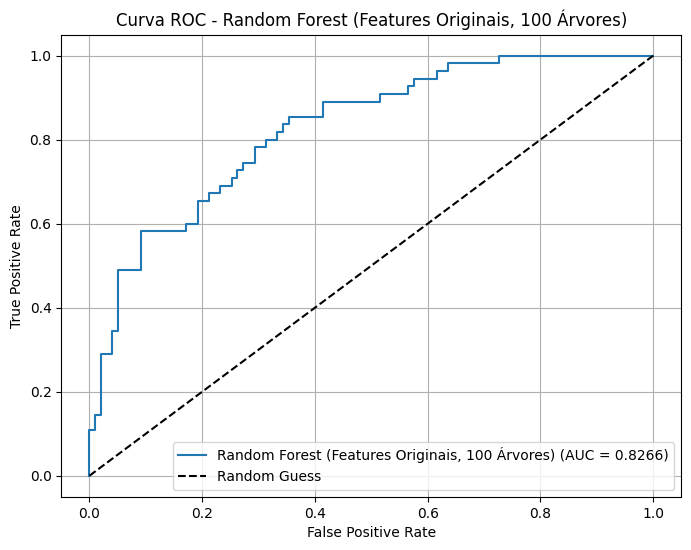


Avaliação de Random Forest com Features Expandidas

Avaliação do Random Forest (Features Expandidas, 100 Árvores):
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

AUC-ROC: 0.8230


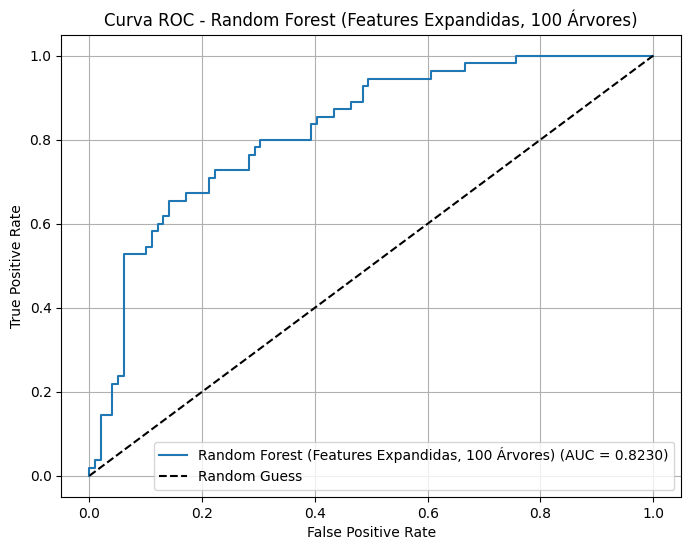

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Função para avaliação de modelos
def evaluate_model(model, test_features, test_target, model_name="Model"):
    # Predições
    predicted_target = model.predict(test_features)
    predicted_probabilities = None
    if hasattr(model, "predict_proba"):  # Verificar se o modelo suporta probabilidades
        predicted_probabilities = model.predict_proba(test_features)[:, 1]

    # Relatório de classificação
    print(f"\nAvaliação do {model_name}:")
    print(classification_report(test_target, predicted_target))

    # Calcular e exibir AUC-ROC se probabilidades estiverem disponíveis
    if predicted_probabilities is not None:
        auc_roc = roc_auc_score(test_target, predicted_probabilities)
        print(f"AUC-ROC: {auc_roc:.4f}")

        # Plotar curva ROC
        fpr, tpr, _ = roc_curve(test_target, predicted_probabilities)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_roc:.4f})")
        plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {model_name}")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
    else:
        print("AUC-ROC não calculado: modelo não suporta probabilidades.")

# Avaliação dos Modelos Treinados

# Avaliação SVM com Features Originais
print("\nAvaliação de SVM com Features Originais")
evaluate_model(svm_models_original['rbf'], test_features_original, test_target, model_name="SVM (Features Originais, RBF)")

# Avaliação SVM com Features Expandidas
print("\nAvaliação de SVM com Features Expandidas")
evaluate_model(svm_models_expanded['rbf'], test_features, test_target, model_name="SVM (Features Expandidas, RBF)")

# Avaliação Random Forest com Features Originais
print("\nAvaliação de Random Forest com Features Originais")
evaluate_model(rf_models_original[100], test_features_original, test_target, model_name="Random Forest (Features Originais, 100 Árvores)")

# Avaliação Random Forest com Features Expandidas
print("\nAvaliação de Random Forest com Features Expandidas")
evaluate_model(rf_models_expanded[100], test_features, test_target, model_name="Random Forest (Features Expandidas, 100 Árvores)")

## 5. Análise Comparativa: Será realizada uma análise comparativa para avaliar o impacto da adição das features de clusterização no desempenho dos modelos de ML. Além disso, será discutida a influência do número de clusters e das configurações do ML nas métricas de desempenho. Use gráficos para ilustrar seus argumentos.

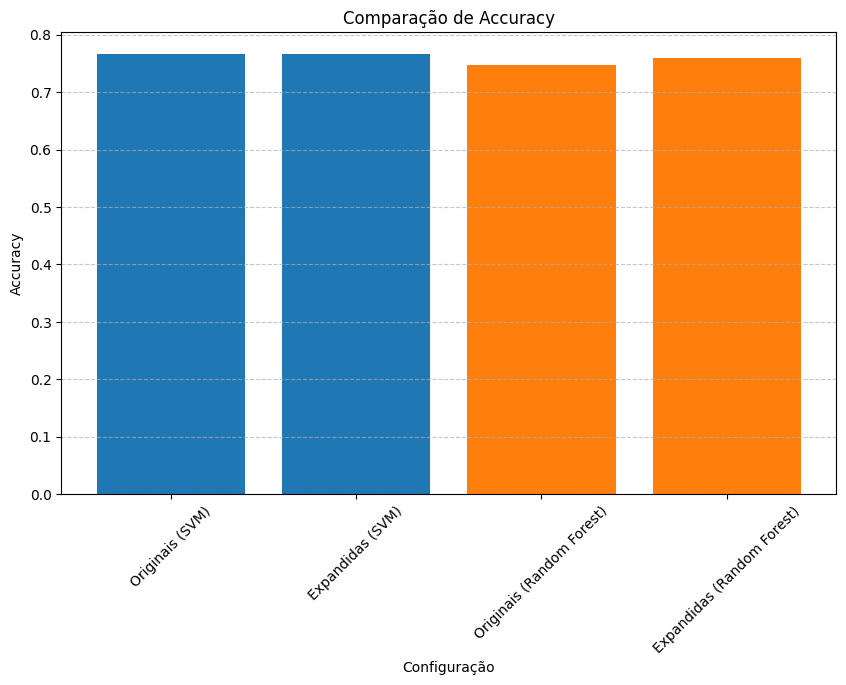

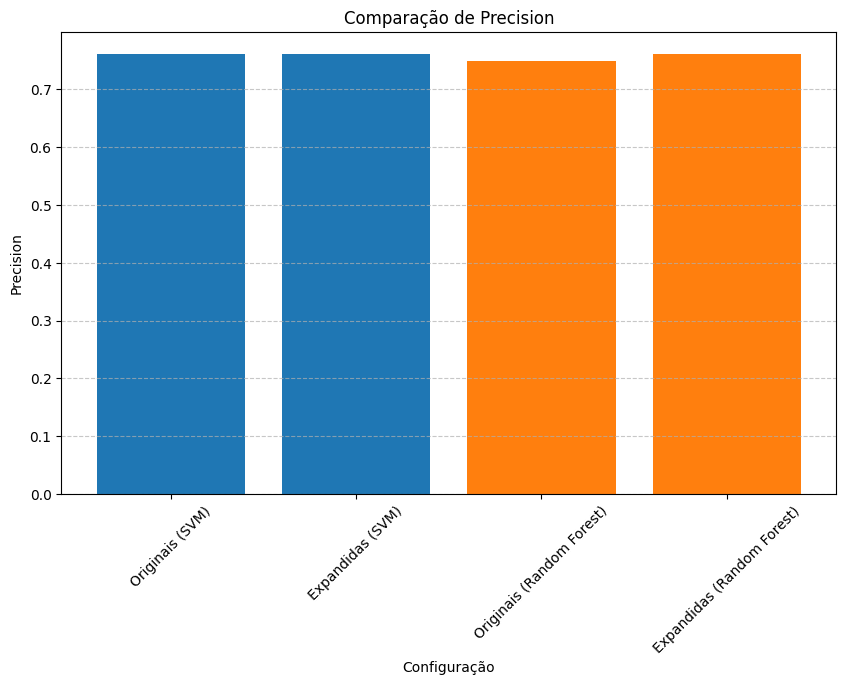

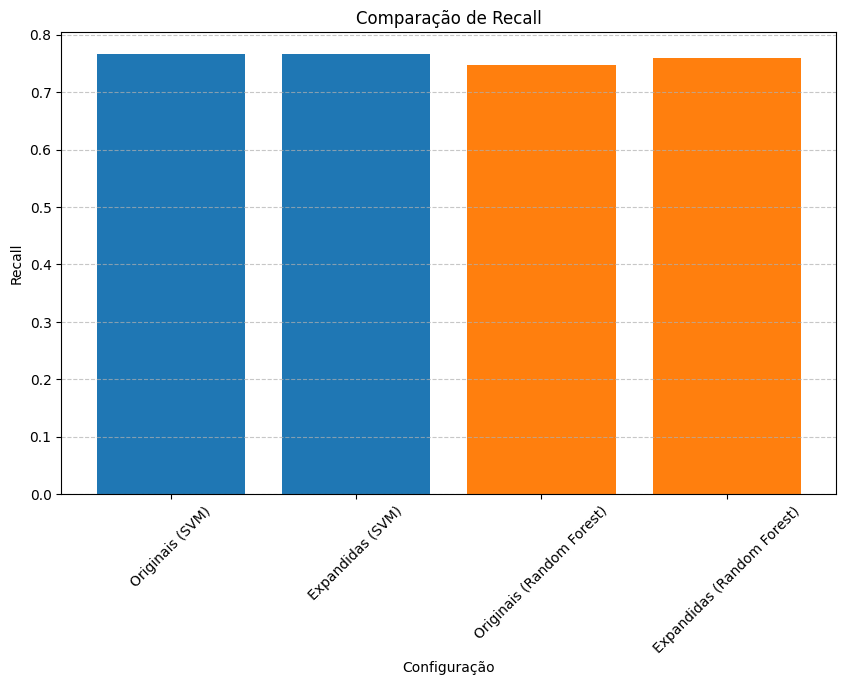

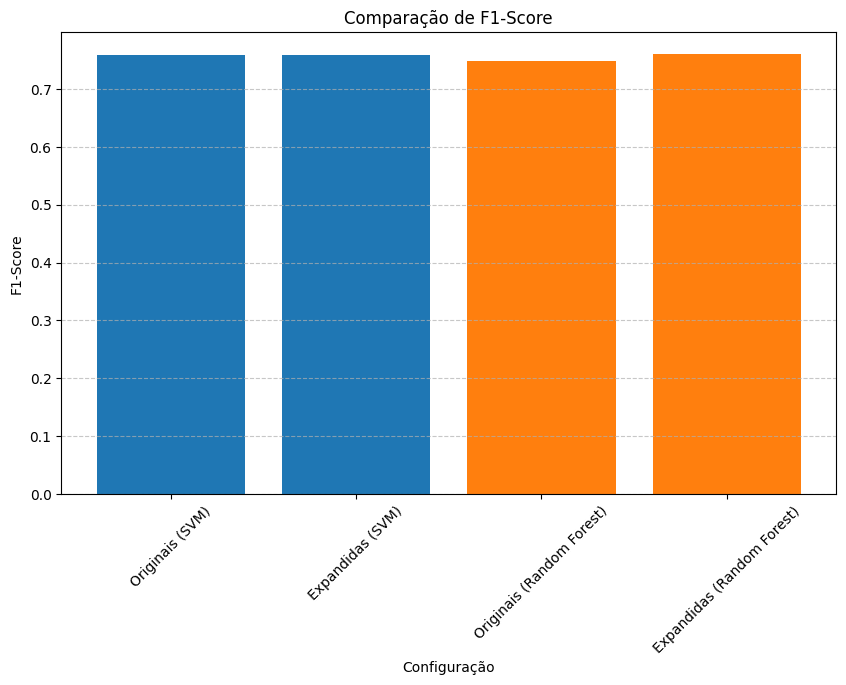

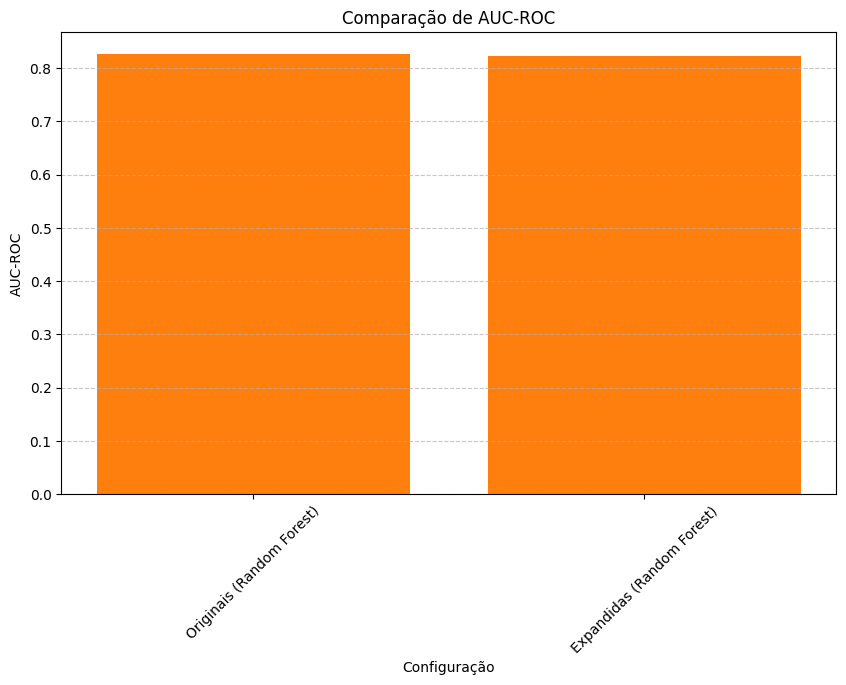

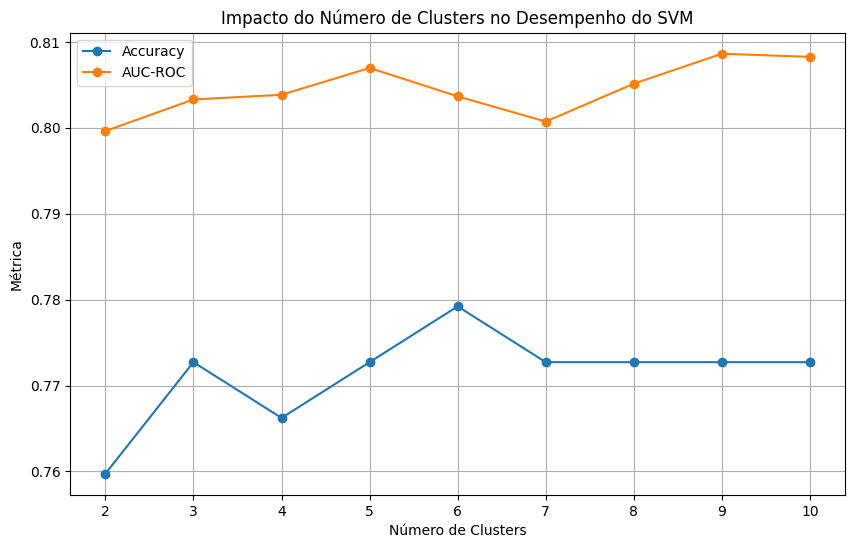

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Dicionário para armazenar métricas comparativas
comparison_metrics = {
    "Model": [],
    "Features": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC-ROC": []
}

# Função para calcular métricas e armazenar
def store_metrics(model, test_features, test_target, model_name, features_type):
    predicted_target = model.predict(test_features)
    predicted_probabilities = model.predict_proba(test_features)[:, 1] if hasattr(model, "predict_proba") else None

    report = classification_report(test_target, predicted_target, output_dict=True)
    accuracy = report["accuracy"]
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]
    auc_roc = roc_auc_score(test_target, predicted_probabilities) if predicted_probabilities is not None else None

    comparison_metrics["Model"].append(model_name)
    comparison_metrics["Features"].append(features_type)
    comparison_metrics["Accuracy"].append(accuracy)
    comparison_metrics["Precision"].append(precision)
    comparison_metrics["Recall"].append(recall)
    comparison_metrics["F1-Score"].append(f1_score)
    comparison_metrics["AUC-ROC"].append(auc_roc)

# SVM com features originais
store_metrics(svm_models_original['rbf'], test_features_original, test_target, "SVM", "Originais")

# SVM com features expandidas
store_metrics(svm_models_expanded['rbf'], test_features, test_target, "SVM", "Expandidas")

# Random Forest com features originais
store_metrics(rf_models_original[100], test_features_original, test_target, "Random Forest", "Originais")

# Random Forest com features expandidas
store_metrics(rf_models_expanded[100], test_features, test_target, "Random Forest", "Expandidas")

# Converter para DataFrame para análise
metrics_df = pd.DataFrame(comparison_metrics)

def plot_comparison(metrics_df, metric_name):
    plt.figure(figsize=(10, 6))
    for model in metrics_df["Model"].unique():
        subset = metrics_df[metrics_df["Model"] == model]
        plt.bar(
            subset["Features"] + " (" + model + ")",
            subset[metric_name],
            label=model
        )
    plt.title(f"Comparação de {metric_name}")
    plt.xlabel("Configuração")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Plotar comparações para todas as métricas
for metric in ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]:
    plot_comparison(metrics_df, metric)

# Função para analisar diferentes números de clusters
def analyze_cluster_impact(cluster_range, train_features, train_target, test_features, test_target):
    cluster_results = {
        "NumClusters": [],
        "Model": [],
        "Accuracy": [],
        "AUC-ROC": []
    }

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        train_features_copy = train_features.copy()
        test_features_copy = test_features.copy()

        # Adicionar distância ao cluster mais próximo
        kmeans.fit(train_features_copy)
        train_features_copy["Distance_to_Cluster"] = compute_nearest_cluster_distance(train_features_copy, kmeans)
        test_features_copy["Distance_to_Cluster"] = compute_nearest_cluster_distance(test_features_copy, kmeans)

        # Treinar e avaliar SVM com features expandidas
        svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
        svm_model.fit(train_features_copy, train_target)
        predicted_target = svm_model.predict(test_features_copy)
        predicted_probabilities = svm_model.predict_proba(test_features_copy)[:, 1]

        # Métricas
        accuracy = accuracy_score(test_target, predicted_target)
        auc_roc = roc_auc_score(test_target, predicted_probabilities)

        cluster_results["NumClusters"].append(k)
        cluster_results["Model"].append("SVM")
        cluster_results["Accuracy"].append(accuracy)
        cluster_results["AUC-ROC"].append(auc_roc)

    return pd.DataFrame(cluster_results)

# Analisar impacto de diferentes números de clusters
cluster_range = range(2, 11)  # De 2 a 10 clusters
cluster_analysis_df = analyze_cluster_impact(cluster_range, train_features, train_target, test_features, test_target)

# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(cluster_analysis_df["NumClusters"], cluster_analysis_df["Accuracy"], label="Accuracy", marker="o")
plt.plot(cluster_analysis_df["NumClusters"], cluster_analysis_df["AUC-ROC"], label="AUC-ROC", marker="o")
plt.title("Impacto do Número de Clusters no Desempenho do SVM")
plt.xlabel("Número de Clusters")
plt.ylabel("Métrica")
plt.legend()
plt.grid()
plt.show()